# Ex10

In [ ]:
import numpy as np
import pandas as pd
import re
import shutil
import os
import unicodedata
import urllib3
import zipfile
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

### 정제, 정규화, 전처리 (영어, 프랑스어 모두 !)

In [ ]:
# 데이터 로드

http = urllib3.PoolManager()
url ='http://www.manythings.org/anki/fra-eng.zip'
filename = 'fra-eng.zip'
path = os.getcwd()
zipfilename = os.path.join(path, filename)
with http.request('GET', url, preload_content=False) as r, open(zipfilename, 'wb') as out_file:       
    shutil.copyfileobj(r, out_file)

with zipfile.ZipFile(zipfilename, 'r') as zip_ref:
    zip_ref.extractall(path)

In [ ]:
# 총 33,000개의 샘플을 사용할 예정

num_samples = 33000

In [ ]:
# 전처리 함수 구현

def unicode_to_ascii(s):
  return ''.join(c for c in unicodedata.normalize('NFD', s)
      if unicodedata.category(c) != 'Mn')

In [ ]:
def preprocess_sentence(sent):
    # 위에서 구현한 함수를 내부적으로 호출
    sent = unicode_to_ascii(sent.lower())

    # 단어와 구두점 사이에 공백을 만듭니다.
    # Ex) "he is a boy." => "he is a boy ."
    sent = re.sub(r"([?.!,¿])", r" \1", sent)

    # (a-z, A-Z, ".", "?", "!", ",") 이들을 제외하고는 전부 공백으로 변환합니다.
    sent = re.sub(r"[^a-zA-Z!.?]+", r" ", sent)

    sent = re.sub(r"\s+", " ", sent)
    return sent

In [ ]:
# 구현한 전처리 함수 테스트 : 임의의 문장 입력
# 전처리 테스트
en_sent = u"Have you had dinner?"
fr_sent = u"Avez-vous déjà diné?"
print(preprocess_sentence(en_sent))
print(preprocess_sentence(fr_sent).encode('utf-8'))

샘플 데이터를 불러와 모든 전처리를 수행하는 함수 구현

- teacher forcing을 위해 디코더의 입/출력 시퀀스를 따로 분리하여 저장
- 입출력 심볼 추가
- 총 3개의 데이터 셋 생성: 인코더의 입력, 디코더의 입력, 디코더의 실제값

In [ ]:
def load_preprocessed_data():
    encoder_input, decoder_input, decoder_target = [], [], []

    with open("fra.txt", "r") as lines:
        for i, line in enumerate(lines):

            # source 데이터와 target 데이터 분리
            src_line, tar_line, _ = line.strip().split('\t')

            # source 데이터 전처리
            src_line_input = [w for w in preprocess_sentence(src_line).split()]

            # target 데이터 전처리
            tar_line = preprocess_sentence(tar_line)
            tar_line_input = [w for w in ("<sos> " + tar_line).split()]
            tar_line_target = [w for w in (tar_line + " <eos>").split()]

            encoder_input.append(src_line_input)
            decoder_input.append(tar_line_input)
            decoder_target.append(tar_line_target)

            if i == num_samples - 1:
                break

    return encoder_input, decoder_input, decoder_target

In [ ]:
# 데이터셋 출력하여 확인

sents_en_in, sents_fra_in, sents_fra_out = load_preprocessed_data()
print(sents_en_in[:5])
print(sents_fra_in[:5])
print(sents_fra_out[:5])

- 단어집합 생성
- 정수 인코딩

In [ ]:
tokenizer_en = Tokenizer(filters="", lower=False)
tokenizer_en.fit_on_texts(sents_en_in)
encoder_input = tokenizer_en.texts_to_sequences(sents_en_in)

tokenizer_fra = Tokenizer(filters="", lower=False)
tokenizer_fra.fit_on_texts(sents_fra_in)
tokenizer_fra.fit_on_texts(sents_fra_out)
decoder_input = tokenizer_fra.texts_to_sequences(sents_fra_in)
decoder_target = tokenizer_fra.texts_to_sequences(sents_fra_out)

- 패딩

In [ ]:
encoder_input = pad_sequences(encoder_input, padding="post")
decoder_input = pad_sequences(decoder_input, padding="post")
decoder_target = pad_sequences(decoder_target, padding="post")

- 단어 집합의 크기 정의

In [ ]:
src_vocab_size = len(tokenizer_en.word_index) + 1
tar_vocab_size = len(tokenizer_fra.word_index) + 1
print("영어 단어 집합의 크기 : {:d}, 프랑스어 단어 집합의 크기 : {:d}".format(src_vocab_size, tar_vocab_size))

- 단어로부터 정수를 얻는 딕셔너리와
- 정수로부터 단어를 얻는 딕셔너리를 각각 생성

In [ ]:
src_to_index = tokenizer_en.word_index
index_to_src = tokenizer_en.index_word # 훈련 후 결과 비교할 때 사용

tar_to_index = tokenizer_fra.word_index # 훈련 후 예측 과정에서 사용
index_to_tar = tokenizer_fra.index_word # 훈련 후 결과 비교할 때 사용

테스트 데이터 분리
- 적절한 분포를 갖도록 데이터를 섞어 줌

In [ ]:
# 순서가 섞인 정수 시퀀스 리스트 생성

indices = np.arange(encoder_input.shape[0])
np.random.shuffle(indices)
print(indices)

In [ ]:
# 이를 데이터셋의 순서로 지정해주면 샘플들이 기존 순서와 다른 순서로 섞임

encoder_input = encoder_input[indices]
decoder_input = decoder_input[indices]
decoder_target = decoder_target[indices]

In [ ]:
# 확인

encoder_input[30997]

In [ ]:
decoder_input[30997]

In [ ]:
decoder_target[30997]

- 훈련 데이터의 10%를 테스트 데이터로 분리

In [ ]:
n_of_val = int(33000*0.1)
print(n_of_val)

In [ ]:
# 33,000개의 10%에 해당되는 3,300개의 데이터를 테스트 데이터로 사용

encoder_input_train = encoder_input[:-n_of_val]
decoder_input_train = decoder_input[:-n_of_val]
decoder_target_train = decoder_target[:-n_of_val]

encoder_input_test = encoder_input[-n_of_val:]
decoder_input_test = decoder_input[-n_of_val:]
decoder_target_test = decoder_target[-n_of_val:]

In [ ]:
# 훈련 데이터와 테스트 데이터의 크기(shape)를 출력

print(encoder_input_train.shape)
print(decoder_input_train.shape)
print(decoder_target_train.shape)
print(encoder_input_test.shape)
print(decoder_input_test.shape)
print(decoder_target_test.shape)

2. 기계 번역기 만들기

In [ ]:
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Masking
from tensorflow.keras.models import Model

In [ ]:
# 임베딩 벡터와 LSTM의 은닉 상태의 크기를 50으로 고정

latent_dim = 50

- 모델 설계

In [ ]:
# 인코더

encoder_inputs = Input(shape=(None,))
enc_emb =  Embedding(src_vocab_size, latent_dim)(encoder_inputs) # 임베딩 층
enc_masking = Masking(mask_value=0.0)(enc_emb) # 패딩 0은 연산에서 제외
encoder_lstm = LSTM(latent_dim, return_state=True) # 상태값 리턴을 위해 return_state는 True
encoder_outputs, state_h, state_c = encoder_lstm(enc_masking) # 은닉 상태와 셀 상태를 리턴
encoder_states = [state_h, state_c] # 인코더의 은닉 상태와 셀 상태를 저장

In [ ]:
# 디코더

decoder_inputs = Input(shape=(None,))
dec_emb_layer = Embedding(tar_vocab_size, latent_dim) # 임베딩 층
dec_emb = dec_emb_layer(decoder_inputs) # 패딩 0은 연산에서 제외
dec_masking = Masking(mask_value=0.0)(dec_emb)

# 상태값 리턴을 위해 return_state는 True, 모든 시점에 대해서 단어를 예측하기 위해 return_sequences는 True
decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True) 

# 인코더의 은닉 상태를 초기 은닉 상태(initial_state)로 사용
decoder_outputs, _, _ = decoder_lstm(dec_masking,
                                     initial_state=encoder_states)

# 모든 시점의 결과에 대해서 소프트맥스 함수를 사용한 출력층을 통해 단어 예측
decoder_dense = Dense(tar_vocab_size, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)

In [ ]:
# 모델 정의

model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

- 훈련 실행

In [ ]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy', metrics=['acc'])

# 현재 decoder_outputs의 경우에는 원-핫 인코딩을 하지 않은 상태이므로
# sparse_categorical_crossentropy를 사용

In [ ]:
model.summary()

In [ ]:
model.fit(x = [encoder_input_train, decoder_input_train], y = decoder_target_train, \
          validation_data = ([encoder_input_test, decoder_input_test], decoder_target_test),
          batch_size = 128, epochs = 50)

3. seq2seq 기계 번역기 동작시키기

In [ ]:
# 테스트를 위해 모델 재설계

# 인코더
encoder_model = Model(encoder_inputs, encoder_states)

# 디코더
# 이전 시점의 상태를 보관할 텐서
decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

# 훈련 때 사용했던 임베딩 층을 재사용
dec_emb2= dec_emb_layer(decoder_inputs)

# 다음 단어 예측을 위해 이전 시점의 상태를 현 시점의 초기 상태로 사용
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=decoder_states_inputs)
decoder_states2 = [state_h2, state_c2]

# 모든 시점에 대해서 단어 예측
decoder_outputs2 = decoder_dense(decoder_outputs2)

In [ ]:
# 디코더 정의

decoder_model = Model(
    [decoder_inputs] + decoder_states_inputs,
    [decoder_outputs2] + decoder_states2)

- 테스트 과정에서의 동작을 위한 decode_sequence 함수를 구현

In [ ]:
def decode_sequence(input_seq):
    # 입력으로부터 인코더의 상태를 얻음
    states_value = encoder_model.predict(input_seq)

    # <SOS>에 해당하는 정수 생성
    target_seq = np.zeros((1,1))
    target_seq[0, 0] = tar_to_index['<sos>']

    stop_condition = False
    decoded_sentence = ''

    # stop_condition이 True가 될 때까지 루프 반복
    # 구현의 간소화를 위해서 이 함수는 배치 크기를 1로 가정합니다.
    while not stop_condition:
        # 이점 시점의 상태 states_value를 현 시점의 초기 상태로 사용
        output_tokens, h, c = decoder_model.predict([target_seq] + states_value)

        # 예측 결과를 단어로 변환
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_char = index_to_tar[sampled_token_index]

         # 현재 시점의 예측 단어를 예측 문장에 추가
        decoded_sentence += ' '+sampled_char

        # <eos>에 도달하거나 정해진 길이를 넘으면 중단.
        if (sampled_char == '<eos>' or
           len(decoded_sentence) > 50):
            stop_condition = True

        # 현재 시점의 예측 결과를 다음 시점의 입력으로 사용하기 위해 저장
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # 현재 시점의 상태를 다음 시점의 상태로 사용하기 위해 저장
        states_value = [h, c]

    return decoded_sentence

- 결과 확인을 위한 함수 구현

In [ ]:
# 원문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2src(input_seq):
    temp=''
    for i in input_seq:
        if(i!=0):
            temp = temp + index_to_src[i]+' '
    return temp

# 번역문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2tar(input_seq):
    temp=''
    for i in input_seq:
        if((i!=0 and i!=tar_to_index['<sos>']) and i!=tar_to_index['<eos>']):
            temp = temp + index_to_tar[i] + ' '
    return temp

- 훈련 데이터에 대해서 임의로 선택한 인덱스의 샘플의 결과를 출력

In [ ]:
for seq_index in [3,50,100,300,1001]:
  input_seq = encoder_input_train[seq_index: seq_index + 1]
  decoded_sentence = decode_sequence(input_seq)

  print("원문 : ",seq2src(encoder_input_train[seq_index]))
  print("번역문 :",seq2tar(decoder_input_train[seq_index]))
  print("예측문 :",decoded_sentence[:-5])
  print("\n")

- 테스트 데이터에 대해서 임의로 선택한 인덱스의 샘플의 결과를 출력

In [ ]:
for seq_index in [3,50,100,300,1001]:
  input_seq = encoder_input_test[seq_index: seq_index + 1]
  decoded_sentence = decode_sequence(input_seq)

  print("원문 : ",seq2src(encoder_input_test[seq_index]))
  print("번역문 :",seq2tar(decoder_input_test[seq_index]))
  print("예측문 :",decoded_sentence[:-5])
  print("\n")

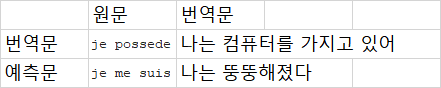

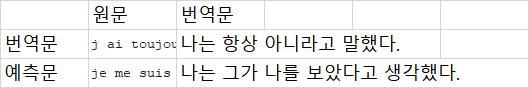

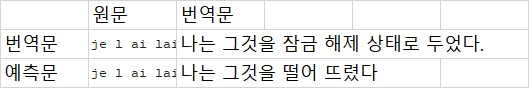

image.png

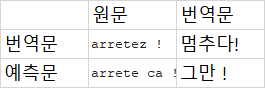

마지막 문장을 제외하고, 주어는 맞췄지만, 전체적으로 번역기가 잘 작동하지 않았다.

### 회고

이번 익스플레이션은 노드 순서에 따라 차근차근 진행하니 별 다른 어려움 없이 진행할 수 있었다. 다만.... 번역기 성능을 신경 안 썼을 때의 말이다. 번역기 성능을 올리고 싶어 여러 시도를 해봤지만, 여지 없이 실패했다.

이번 주는 개인적인 사정으로 공부를 열심히 하지 못했다. 그래서 익스를 끝마치는 시점에도 전반적인 이해도가 많이 떨어지는 거 같다.

이번에는 동욱님의 도움을 많이 받았다. 애로사항을 말하니 자신이 작성한 코드를 보여주며 설명해주셨다.감사하다고 말하고 싶다.